(30, 30)


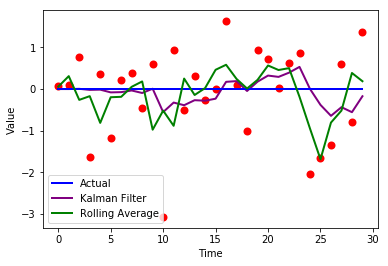

In [48]:
import cv2, numpy as np
import time, random
import matplotlib 
import matplotlib.pyplot as plt

meas=[]
pred=[]
mp = np.array((1,1),np.float32) # measurement
tp = np.zeros((1,1),np.float32) # tracked / prediction

kalman = cv2.KalmanFilter(2,1) # 2D state (distance and velocity), 1D measurement (distance)
kalman.measurementMatrix = np.array([[1,1]], np.float32)
kalman.transitionMatrix = np.array([[1,1], [0,1]], np.float32)
kalman.processNoiseCov = np.array([[1,0], [0,1]], np.float32) * 0.00003
kalman.measurementNoiseCov = np.array([[1]], np.float32) * 0.03

steps = 30
for i in range(steps):
        mp = np.array([[np.random.normal(0, 1.0)]], np.float32)
        meas.append(mp[0])
        kalman.correct(mp)
        tp = kalman.predict()
        pred.append(tp[0])
        #print("Measured: %s, estimated: %s" % (mp[0], tp[0]))
        #time.sleep(0.1)

actual = [0 for x in range(steps)] 
meas = [x[0] for x in meas]
rolling_avg = np.convolve(meas, [1.0/3,1.0/3,1.0/3], 'same')

time = np.arange(0, steps)
print(len(time), len(meas))
plt.scatter(time, meas, label = "Measured", lw = 2.0, c = "red")
est_lab, = plt.plot(time, pred, label = "Kalman Filter", lw = 2.0, c = "purple")
act_lab, = plt.plot(time, actual, label = "Actual", lw = 2.0, c = "blue")
avg_lab, = plt.plot(time, rolling_avg, label = "Rolling Average", lw = 2.0, c = "green")


plt.legend(handles=[act_lab, est_lab, avg_lab])
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [26]:
x_list = range(10)
np.convolve(x_list, [1.0/3,1.0/3,1.0/3], 'same')

array([ 0.33333333,  1.        ,  2.        ,  3.        ,  4.        ,
        5.        ,  6.        ,  7.        ,  8.        ,  5.66666667])

In [27]:
meas

[array([-0.98258477], dtype=float32),
 array([-1.57851541], dtype=float32),
 array([-1.66926575], dtype=float32),
 array([-0.63036269], dtype=float32),
 array([-0.30143127], dtype=float32),
 array([-0.88148171], dtype=float32),
 array([ 0.73245358], dtype=float32),
 array([-0.98927951], dtype=float32),
 array([ 1.71003187], dtype=float32),
 array([ 0.01228206], dtype=float32),
 array([-1.61119998], dtype=float32),
 array([-0.83140177], dtype=float32),
 array([-1.39992082], dtype=float32),
 array([-1.0274986], dtype=float32),
 array([ 2.25496864], dtype=float32),
 array([-0.10775625], dtype=float32),
 array([ 0.92425871], dtype=float32),
 array([-1.01388216], dtype=float32),
 array([ 0.12928146], dtype=float32),
 array([-0.00735499], dtype=float32),
 array([-1.05245423], dtype=float32),
 array([ 1.41867805], dtype=float32),
 array([ 1.71366036], dtype=float32),
 array([ 0.82647026], dtype=float32),
 array([ 1.45977902], dtype=float32),
 array([-0.32003337], dtype=float32),
 array([-0.54